Split the data in model_month into training and testing sets.

In [1]:
# Install necessary packages
!pip install dataretrieval
!pip install statsmodels
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
from dataretrieval import nwis
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
import sklearn
#print(sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Print current time
current_time = datetime.now()
print(current_time.strftime("%Y-%m-%d %H:%M:%S"))
startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = ["12305000","12322000"
              ,"13092747","13150430","13154500","13176400","13190500","13192200","13211205","13213000","13296000","13304050","13307000","13310800","13310850","13311000","13311250","13311450","13317660","13337095","13340000","13340600","13341050","13342500"
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

2025-07-30 19:56:57


In [3]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Site information retrieval
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va'
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]


# Stream data retrieval
parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( "dailyStreamtemp_df.head()",dailyStreamtemp_df.head() )

dailyStreamtemp_df.head()       site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
244  12305000 1996-06-01 00:00:00+00:00            NaN              NaN   
245  12305000 1996-06-02 00:00:00+00:00            NaN              NaN   
246  12305000 1996-06-03 00:00:00+00:00            NaN              NaN   
247  12305000 1996-06-04 00:00:00+00:00            NaN              NaN   
248  12305000 1996-06-05 00:00:00+00:00            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN     39200.0   
245            NaN              NaN         NaN           NaN     39400.0   
246            NaN              NaN         NaN           NaN     41300.0   
247            NaN              NaN         NaN           NaN     44400.0   
248            NaN              NaN         NaN           NaN     42700.0   

    00060_Mean_cd  ...  00010_2_Mean_cd 00010_temperature ys

In [5]:
dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]

print(dailyStreamtemp_df.head())

      site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
244  12305000 1996-06-01 00:00:00+00:00            NaN              NaN   
245  12305000 1996-06-02 00:00:00+00:00            NaN              NaN   
246  12305000 1996-06-03 00:00:00+00:00            NaN              NaN   
247  12305000 1996-06-04 00:00:00+00:00            NaN              NaN   
248  12305000 1996-06-05 00:00:00+00:00            NaN              NaN   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
244            NaN              NaN         NaN           NaN     39200.0   
245            NaN              NaN         NaN           NaN     39400.0   
246            NaN              NaN         NaN           NaN     41300.0   
247            NaN              NaN         NaN           NaN     44400.0   
248            NaN              NaN         NaN           NaN     42700.0   

    00060_Mean_cd  ...  00010_2_Mean_cd 00010_temperature ysi_Maximum  \
244          

In [6]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date'])
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date
print( prism_df)

             date      tmean   site_no  Days_Since_October_1st     rad_d  \
0      1995-01-01 -18.306002  06038800                      92  1.583707   
1      1995-01-02 -17.829000  06038800                      93  1.600921   
2      1995-01-03 -18.317001  06038800                      94  1.618135   
3      1995-01-04 -15.904000  06038800                      95  1.635350   
4      1995-01-05 -11.903001  06038800                      96  1.652564   
...           ...        ...       ...                     ...       ...   
282875 2024-10-10  14.149199  13342500                       9  0.154928   
282876 2024-10-11  13.611249  13342500                      10  0.172142   
282877 2024-10-12  16.385151  13342500                      11  0.189356   
282878 2024-10-13  14.676150  13342500                      12  0.206570   
282879 2024-10-14  16.204950  13342500                      13  0.223785   

              Date  
0       1995-01-01  
1       1995-01-02  
2       1995-01-03  
3  

In [7]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean',
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')



# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print("na_count:",na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )

df_cleaned.to_csv("/content/drive/MyDrive/df_cleaned_summer.csv", index=False)

na_count: tmean                         0
site_no                       0
Date                          0
rad_d                         0
Days_Since_October_1st        0
00010_Mean                13327
00060_Mean                 2254
Month                         0
Year                          0
dtype: int64
        tmean   site_no        Date     rad_d  Days_Since_October_1st  \
42  23.403002  13092747  1996-07-13  4.906049                     285   
43  23.366001  13092747  1996-07-14  4.923263                     286   
44  24.110001  13092747  1996-07-15  4.940477                     287   
45  21.022001  13092747  1996-07-16  4.957691                     288   
46  21.528002  13092747  1996-07-17  4.974906                     289   

    00010_Mean  00060_Mean  Month  Year  
42        18.6       120.0      7  1996  
43        18.4       130.0      7  1996  
44        18.3       132.0      7  1996  
45        17.9       134.0      7  1996  
46        18.0       155.0      7  1996 

 iterates through a list of sites (presumably site numbers or identifiers), filters a DataFrame (df_cleaned) for each site, and then prepares the data for a time-series-based machine learning model by splitting it into training and testing sets.

In [8]:
y_train_all = pd.DataFrame( {})
y_test_all = pd.DataFrame( {})

train_df_all = pd.DataFrame( {})
test_df_all = pd.DataFrame( {})

for site in model_site:
    print("site:", site)
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    num_rows = merged_df_wy.shape[0]
    input=  merged_df_wy[  idv]

    if num_rows <90:
        print("stop:", site)
    else:
        # Sort the DataFrame by date to ensure chronological order
        merged_df_wy = merged_df_wy.sort_values(by='Date').reset_index(drop=True)

        # Determine the split point for 80% of the data
        train_size = int(0.8 * len( merged_df_wy ))

        # Split the DataFrame into training and testing sets
        train_df =  merged_df_wy.iloc[:train_size].copy()
        test_df =  merged_df_wy.iloc[train_size:].copy()
        X_train=train_df[idv]
        X_test=test_df[idv]
        y_test=test_df[ "00010_Mean"]
        y_train=train_df[ "00010_Mean"]
        #print( "len(y_train)", len(y_train))
        #print("len(y_test", len(y_test))
        #print( "y_train.tail()",  y_train.tail() )
        #print(" y_test.head()", y_test.head() )
        print("train_df.tail()",train_df.tail())
        y_train_all  = pd.concat([ y_train_all , y_train ])
        y_test_all  = pd.concat([ y_test_all , y_test ])
        train_df_all  = pd.concat([ train_df_all , train_df ])
        test_df_all  = pd.concat([ test_df_all , test_df ])

site: 12305000
train_df.tail()        tmean   site_no        Date     rad_d  Days_Since_October_1st  \
867  15.0209  12305000  2022-06-12  4.372408                     254   
868   8.8299  12305000  2022-06-13  4.389623                     255   
869   7.8279  12305000  2022-06-14  4.406837                     256   
870  14.0716  12305000  2022-06-15  4.424051                     257   
871  17.4758  12305000  2022-06-16  4.441265                     258   

     00010_Mean  00060_Mean  Month  Year  
867        10.0     35000.0      6  2022  
868         9.5     34000.0      6  2022  
869         8.2     33000.0      6  2022  
870         9.1     31000.0      6  2022  
871        10.1     27900.0      6  2022  
site: 12322000
train_df.tail()          tmean   site_no        Date     rad_d  Days_Since_October_1st  \
757  25.911900  12322000  2022-08-08  5.353618                     311   
758  24.969000  12322000  2022-08-09  5.370832                     312   
759  24.472099  12322000 

In [9]:
y_train_all['00010_Mean']
y_test_all['00010_Mean']

,00010_Mean
872,10.9
873,11.1
874,11.1
875,10.7
876,11.0
...,...
2282,11.4
2283,10.9
2284,11.1
2285,11.3


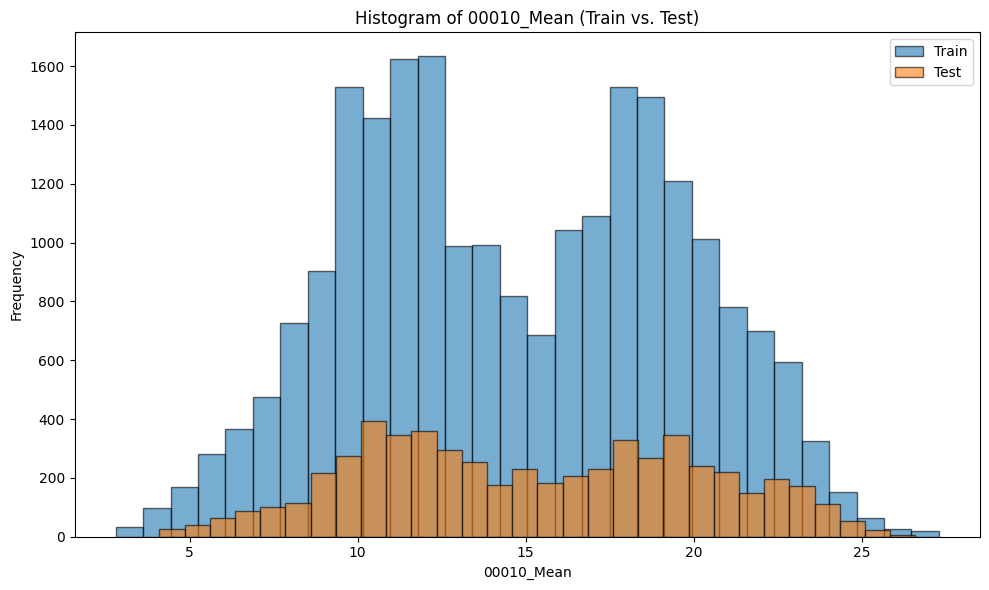

In [10]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(y_train_all['00010_Mean'], bins=30, alpha=0.6, label='Train', edgecolor='black')
plt.hist(y_test_all['00010_Mean'], bins=30, alpha=0.6, label='Test', edgecolor='black')

# Add labels and legend
plt.xlabel('00010_Mean')
plt.ylabel('Frequency')
plt.title('Histogram of 00010_Mean (Train vs. Test)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

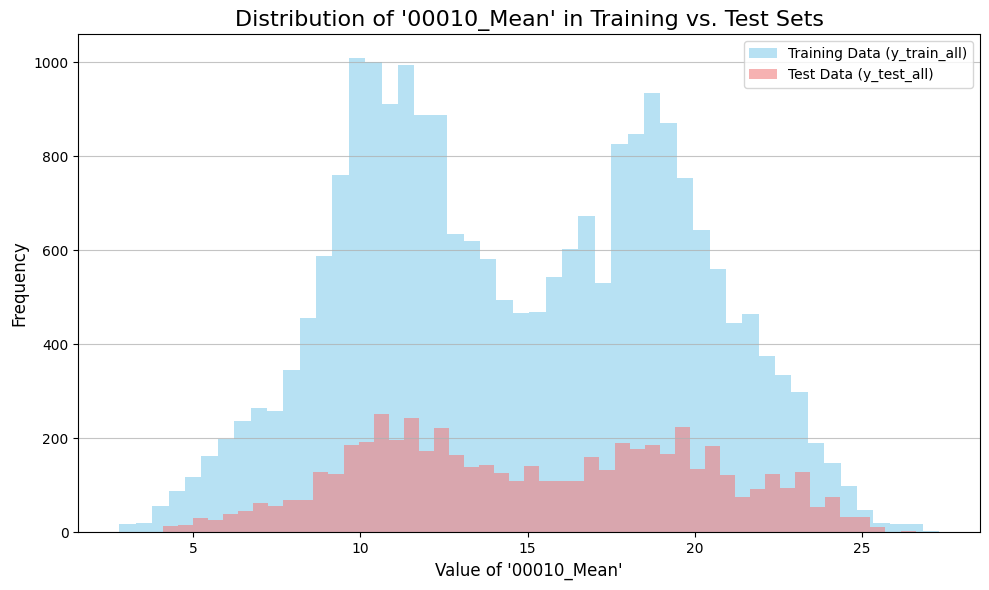

In [11]:
# --- Create the Histograms ---
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

# Histogram for y_train_all['00010_Mean']
# 'bins' determines the number of bars. 'alpha' sets transparency for overlap.
# 'label' is used for the legend.
plt.hist(y_train_all['00010_Mean'], bins=50, alpha=0.6, label='Training Data (y_train_all)', color='skyblue')

# Histogram for y_test_all['00010_Mean']
plt.hist(y_test_all['00010_Mean'], bins=50, alpha=0.6, label='Test Data (y_test_all)', color='lightcoral')

# Add titles and labels for clarity
plt.title('Distribution of \'00010_Mean\' in Training vs. Test Sets', fontsize=16)
plt.xlabel('Value of \'00010_Mean\'', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add a legend to differentiate between the two histograms
plt.legend(fontsize=10)

# Add a grid for easier reading of values
plt.grid(axis='y', alpha=0.75)

# Tight layout to prevent labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

https://docs.google.com/presentation/d/1ru7PO57gi_dFhiGsdzuhGvnTDmkFCPDb4F2sPazVmow/edit?usp=sharing

       tmean   site_no        Date     rad_d  Days_Since_October_1st  \
0  15.100000  12305000  2012-06-01  4.183052                     243   
1  13.240001  12305000  2012-06-02  4.200266                     244   
2  14.009001  12305000  2012-06-03  4.217481                     245   
3  16.588001  12305000  2012-06-04  4.234695                     246   
4  10.858001  12305000  2012-06-05  4.251909                     247   

   00010_Mean  00060_Mean  Month  Year    set  
0         8.5     31500.0      6  2012  Train  
1         8.5     37500.0      6  2012  Train  
2         8.5     40100.0      6  2012  Train  
3         9.5     39900.0      6  2012  Train  
4        10.0     42200.0      6  2012  Train  


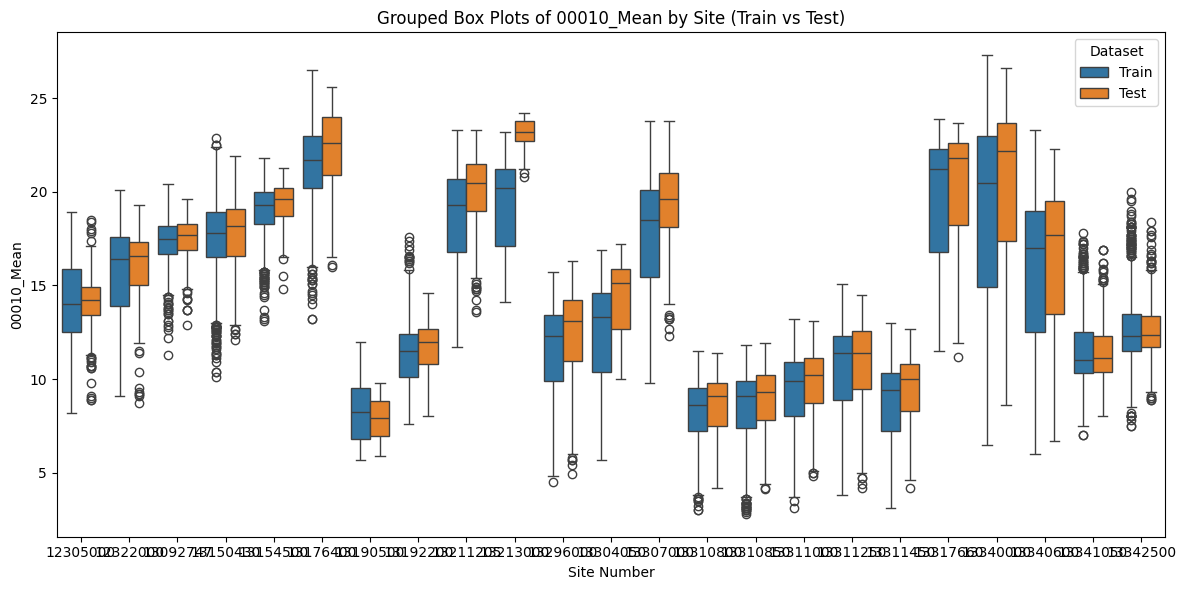

In [12]:
# Add a label column to distinguish train/test
train_df_all['set'] = 'Train'
test_df_all['set'] = 'Test'
print(train_df_all.head())

# Combine both DataFrames
combined_df = pd.concat([ train_df_all ,  test_df_all ], ignore_index=True)

# Plot grouped box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='site_no', y='00010_Mean', hue='set')

plt.title('Grouped Box Plots of 00010_Mean by Site (Train vs Test)')
plt.xlabel('Site Number')
plt.ylabel('00010_Mean')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()